In [1]:
from pathlib import Path 
import os, dotenv
dotenv.load_dotenv()
os.chdir(Path(os.getenv("PYTHONPATH")).expanduser())

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.preprocessing.tokenize_qwen import load_qwen_tokenizer, tokenize_df, expand_chunked_df

/opt/anaconda3/envs/InsureHub/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1. Load your JSONL file
VARIANT = "nocomments"  # Options: "hybrid", "nocomments", "nomods"
source_code_df = pd.read_json(f"data/training_datasets/verified_{VARIANT}.jsonl", lines=True)
#nocomment_df = pd.read_json("data/training_datasets/verified_nocomments.jsonl", lines=True)
#nomod_df = pd.read_json("data/training_datasets/verified_nomods.jsonl", lines=True)
metrics_df = pd.read_csv("data/file_metrics.csv")
syntax_df = pd.read_json("data/training_datasets/syntax_check/cry_saw_syntax_verification_results.jsonl", lines=True)
# Keep only files that passed syntax check
source_code_df = source_code_df[source_code_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
#nocomment_df = nocomment_df[nocomment_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
#nomod_df = nomod_df[nomod_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
metrics_df = metrics_df[metrics_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
# 2. Load tokenizer
model_name = "Qwen/Qwen3-Coder-30B-A3B-Instruct"
tokenizer = load_qwen_tokenizer(model_name)

# 3. Tokenize
source_code_tok_df = tokenize_df(source_code_df, tokenizer)
#nocomment_tok_df = tokenize_df(nocomment_df, tokenizer)
#nomod_tok_df = tokenize_df(nomod_df, tokenizer)

metrics_df = metrics_df.merge(source_code_tok_df[["filename", "n_tokens"]], on="filename", how="left")
#metrics_df = metrics_df.rename(columns={"n_tokens": "hybrid_tokens"})
#metrics_df = metrics_df.merge(nocomment_tok_df[["filename", "n_tokens"]], on="filename", how="left")
#metrics_df = metrics_df.rename(columns={"n_tokens": "nocomment_tokens"})
#metrics_df = metrics_df.merge(nomod_tok_df[["filename", "n_tokens"]], on="filename", how="left")
#metrics_df = metrics_df.rename(columns={"n_tokens": "nomod_tokens"})

file_path = Path("data/training_datasets/cleaned_text_data.jsonl")
file_path.parent.mkdir(parents=True, exist_ok=True)  # create dirs if missing
file_path.touch(exist_ok=True)  # create file if missing

text_df = pd.read_json("data/training_datasets/cleaned_text_data.jsonl", lines=True)
text_tok_df = tokenize_df(text_df, tokenizer)
print(text_tok_df["n_tokens"].sum())
text_tok_df.head()

all_df = pd.concat([source_code_df, text_df], ignore_index=True)
#print(hybrid_tok_df[["filename", "n_tokens"]].head())

# 4. Optional: Chunk for training
source_code_chunk_df = expand_chunked_df(source_code_tok_df, tokenizer, max_seq_len=4096, stride=256)
text_chunk_df = expand_chunked_df(text_tok_df, tokenizer, max_seq_len=4096, stride=256)
#nocomment_chunk_df = expand_chunked_df(nocomment_tok_df, tokenizer, max_seq_len=4096, stride=256)
#nomod_chunk_df = expand_chunked_df(nomod_tok_df, tokenizer, max_seq_len=4096, stride=256)

source_code_chunk_df.head()



22399


,filename,chunk_index,input_ids,n_tokens
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,0,"[4352, 38841, 1380, 271, 474, 1565, 10839, 486...",173
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,0,"[4352, 38841, 16, 17, 23, 1380, 271, 474, 1565...",214
2,AES-GCM-SIV-proof/proof/cryptol-specs/intrinsi...,0,"[4352, 60794, 67102, 1380, 271, 474, 1565, 108...",647
3,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,0,"[4352, 38841, 17, 20, 21, 1380, 271, 474, 1565...",214
4,AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry,0,"[1313, 77483, 260, 284, 220, 19, 198, 1313, 32...",3400


In [4]:
all_chunk_df = pd.concat([source_code_chunk_df, text_chunk_df], ignore_index=True)
all_chunk_df.head()

,filename,chunk_index,input_ids,n_tokens
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,0,"[4352, 38841, 1380, 271, 474, 1565, 10839, 486...",173
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,0,"[4352, 38841, 16, 17, 23, 1380, 271, 474, 1565...",214
2,AES-GCM-SIV-proof/proof/cryptol-specs/intrinsi...,0,"[4352, 60794, 67102, 1380, 271, 474, 1565, 108...",647
3,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,0,"[4352, 38841, 17, 20, 21, 1380, 271, 474, 1565...",214
4,AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry,0,"[1313, 77483, 260, 284, 220, 19, 198, 1313, 32...",3400


In [5]:
source_code_tok_df.head()

,filename,filetype,content,variant,input_ids,n_tokens
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,cry,module AES where\n\nimport `Common::AES\n\ntyp...,without_comments,"[4352, 38841, 1380, 271, 474, 1565, 10839, 486...",173
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,cry,module AES128 where\n\nimport `Common::AES\nim...,without_comments,"[4352, 38841, 16, 17, 23, 1380, 271, 474, 1565...",214
2,AES-GCM-SIV-proof/proof/cryptol-specs/intrinsi...,cry,module Intrinsics where\n\nimport `Common::AES...,without_comments,"[4352, 60794, 67102, 1380, 271, 474, 1565, 108...",647
3,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,cry,module AES256 where\n\nimport `Common::AES\nim...,without_comments,"[4352, 38841, 17, 20, 21, 1380, 271, 474, 1565...",214
4,AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry,cry,type Nb = 4\ntype State = [4][Nb]...,without_comments,"[1313, 77483, 260, 284, 220, 19, 198, 1313, 32...",3400


In [6]:
text_tok_df['variant'] = 'formatted'
text_tok_df.head()

,filename,filetype,content,input_ids,n_tokens,variant
0,https://galoisinc.github.io/cryptol/master/Bas...,text,```markdown\n## Basic Syntax\n\n## Declaration...,"[73594, 60073, 198, 565, 14625, 32117, 271, 56...",2550,formatted
1,https://galoisinc.github.io/cryptol/master/Exp...,text,```markdown\n## Expressions\n\nThis section pr...,"[73594, 60073, 198, 565, 17399, 908, 271, 1986...",1037,formatted
2,https://galoisinc.github.io/cryptol/master/Bas...,text,```markdown\n## Basic Types\n\n## Tuples and R...,"[73594, 60073, 198, 565, 14625, 20768, 271, 56...",1585,formatted
3,https://galoisinc.github.io/cryptol/master/Ove...,text,```markdown\n## Overloaded Operations\n\nMany ...,"[73594, 60073, 198, 565, 6065, 15589, 24883, 2...",2808,formatted
4,https://galoisinc.github.io/cryptol/master/Typ...,text,```markdown\n## Type Declarations\n\n### Type ...,"[73594, 60073, 198, 565, 3990, 88275, 271, 143...",2006,formatted


In [7]:
all_tok_df = source_code_tok_df # pd.concat([source_code_tok_df, text_tok_df], ignore_index=True)
print(all_tok_df["n_tokens"].sum())
all_tok_df.head()

861230


,filename,filetype,content,variant,input_ids,n_tokens
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,cry,module AES where\n\nimport `Common::AES\n\ntyp...,without_comments,"[4352, 38841, 1380, 271, 474, 1565, 10839, 486...",173
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,cry,module AES128 where\n\nimport `Common::AES\nim...,without_comments,"[4352, 38841, 16, 17, 23, 1380, 271, 474, 1565...",214
2,AES-GCM-SIV-proof/proof/cryptol-specs/intrinsi...,cry,module Intrinsics where\n\nimport `Common::AES...,without_comments,"[4352, 60794, 67102, 1380, 271, 474, 1565, 108...",647
3,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,cry,module AES256 where\n\nimport `Common::AES\nim...,without_comments,"[4352, 38841, 17, 20, 21, 1380, 271, 474, 1565...",214
4,AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry,cry,type Nb = 4\ntype State = [4][Nb]...,without_comments,"[1313, 77483, 260, 284, 220, 19, 198, 1313, 32...",3400


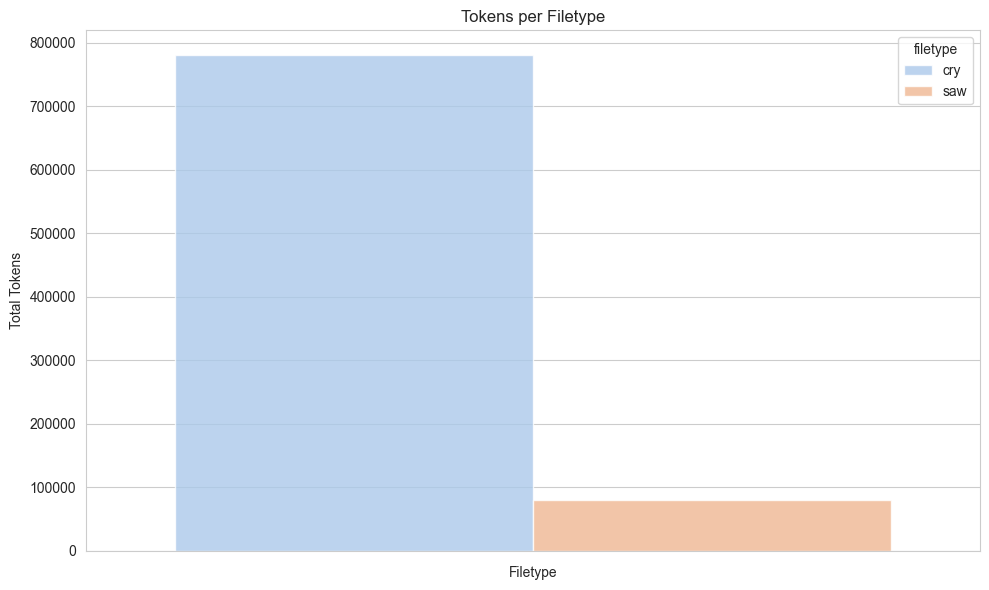

  filetype  n_tokens
0      cry    780708
1      saw     80522
861230 total tokens


In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
grouped = all_tok_df.groupby(['filetype'])['n_tokens'].sum().reset_index()
# Sort by total_tokens descending
grouped = grouped.sort_values('n_tokens', ascending=False)
sns.barplot(data=grouped, hue="filetype", y="n_tokens", alpha=0.8, palette="pastel", legend=True)
plt.title("Tokens per Filetype")
plt.ylabel("Total Tokens")
plt.xlabel("Filetype")
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
print(all_tok_df.groupby("filetype")["n_tokens"].sum().reset_index())
print(f"{all_tok_df['n_tokens'].sum()} total tokens")

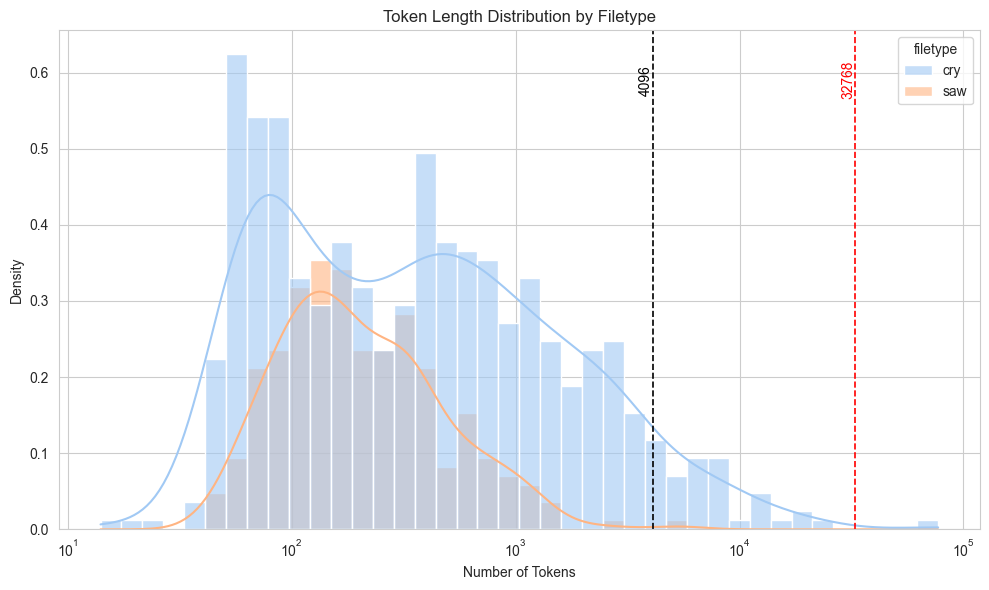

In [9]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10,6))
sns.histplot(data=all_tok_df, x="n_tokens", hue="filetype", kde=True, bins=40, alpha=0.6, log_scale=True, palette="pastel", stat="density")
# Add dashed vertical lines
plt.axvline(x=4096, color="black", linestyle="--", linewidth=1.2)
plt.axvline(x=32768, color="red", linestyle="--", linewidth=1.2)

# Add text labels near the lines
plt.text(4096, plt.ylim()[1]*0.9, "4096", color="black", fontsize=10, ha="right", va="center", rotation=90)
plt.text(32768, plt.ylim()[1]*0.9, "32768", color="red", fontsize=10, ha="right", va="center", rotation=90)
plt.title("Token Length Distribution by Filetype")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

cryptol_filenames = source_code_tok_df[source_code_tok_df["filetype"] == "cry"]["filename"].unique().tolist()
print(f"Cryptol files: {len(cryptol_filenames)}")
saw_filenames = source_code_tok_df[source_code_tok_df["filetype"] == "saw"]["filename"].unique().tolist()
print(f"SAW files: {len(saw_filenames)}")
text_filenames = text_tok_df["filename"].unique().tolist()
print(f"Text files: {len(text_filenames)}")

Cryptol files: 646
SAW files: 262
Text files: 9


In [11]:
unsupervised_sz = 0.75
validation_ratio = .05 / (1 - unsupervised_sz)

unsupervised_filenames = []
supervised_filenames = []
holdout_filenames = []
for filenames in [cryptol_filenames, saw_filenames, text_filenames]:
    unsupervised, temp = train_test_split(filenames, test_size=1 - unsupervised_sz, random_state=42)
    unsupervised_filenames.extend(unsupervised)
    supervised, holdout = train_test_split(temp, test_size=validation_ratio, random_state=42)
    supervised_filenames.extend(supervised)
    holdout_filenames.extend(holdout)
    
print(f"Unsupervised: {len(unsupervised_filenames)} files"
      f", Supervised: {len(supervised_filenames)} files"
      f", Holdout: {len(holdout_filenames)} files")

Unsupervised: 686 files, Supervised: 183 files, Holdout: 48 files


In [12]:
all_df["set"] = ""
all_df.loc[all_df["filename"].isin(unsupervised_filenames), "set"] = "unsupervised"
all_df.loc[all_df["filename"].isin(supervised_filenames), "set"] = "supervised"
all_df.loc[all_df["filename"].isin(holdout_filenames), "set"] = "holdout"

all_tok_df["set"] = ""
all_tok_df.loc[all_tok_df["filename"].isin(unsupervised_filenames), "set"] = "unsupervised"
all_tok_df.loc[all_tok_df["filename"].isin(supervised_filenames), "set"] = "supervised"
all_tok_df.loc[all_tok_df["filename"].isin(holdout_filenames), "set"] = "holdout"

all_df.head()

,filename,filetype,content,variant,set
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,cry,module AES where\n\nimport `Common::AES\n\ntyp...,without_comments,unsupervised
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,cry,module AES128 where\n\nimport `Common::AES\nim...,without_comments,unsupervised
2,AES-GCM-SIV-proof/proof/cryptol-specs/intrinsi...,cry,module Intrinsics where\n\nimport `Common::AES...,without_comments,supervised
3,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,cry,module AES256 where\n\nimport `Common::AES\nim...,without_comments,unsupervised
4,AES-GCM-SIV-proof/proof/cryptol-specs/TBox.cry,cry,type Nb = 4\ntype State = [4][Nb]...,without_comments,unsupervised


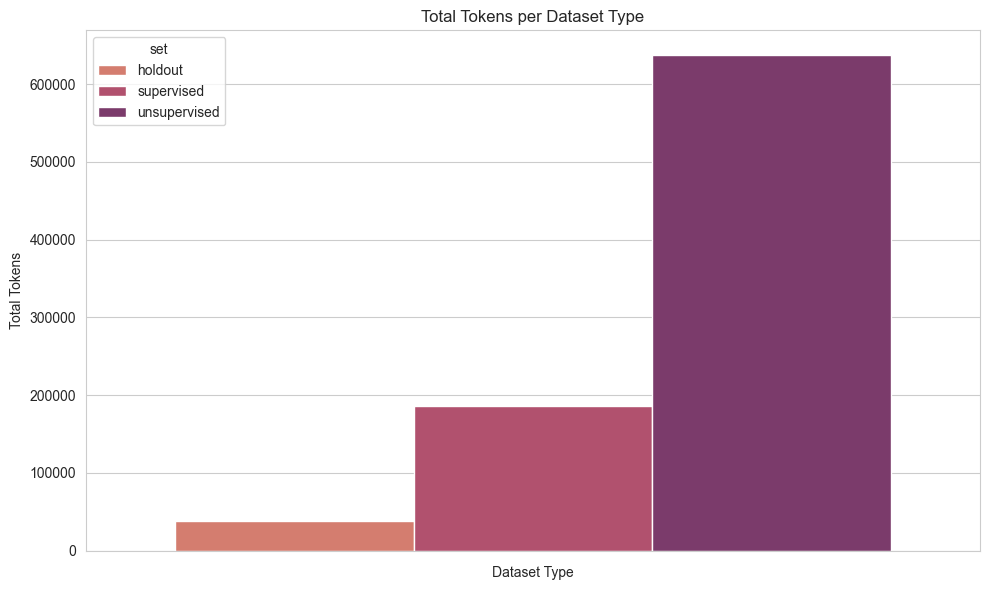

            set  n_tokens
0       holdout     37719
1    supervised    186200
2  unsupervised    637311
Percentages: 
            set   n_tokens
0       holdout   4.379666
1    supervised  21.620241
2  unsupervised  74.000093 


In [13]:
plt.figure(figsize=(10,6))
sns.barplot(data=all_tok_df.groupby("set")["n_tokens"].sum().reset_index(), hue="set", y="n_tokens", palette="flare", legend=True)
plt.title("Total Tokens per Dataset Type")
plt.ylabel("Total Tokens")
plt.xlabel("Dataset Type")
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
total_tokens = all_tok_df['n_tokens'].sum()
print(all_tok_df.groupby("set")["n_tokens"].sum().reset_index())
print(f"Percentages: \n{(all_tok_df.groupby('set')['n_tokens'].sum() / total_tokens * 100).reset_index()} ")

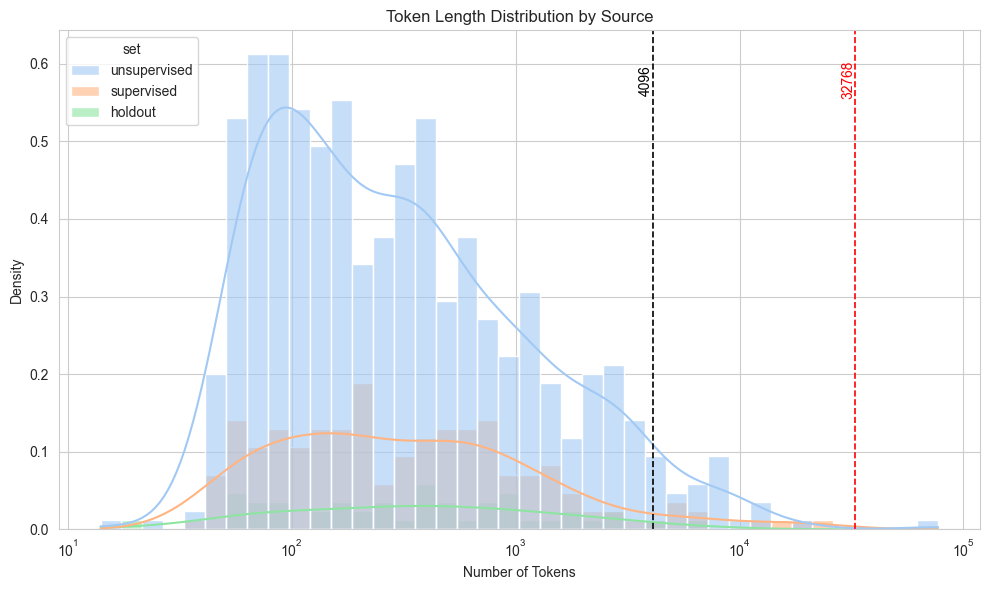

In [14]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10,6))
sns.histplot(data=all_tok_df, x="n_tokens", hue="set", kde=True, bins=40, alpha=0.6, palette="pastel", log_scale=True, stat="density")
# Add dashed vertical lines
plt.axvline(x=4096, color="black", linestyle="--", linewidth=1.2)
plt.axvline(x=32768, color="red", linestyle="--", linewidth=1.2)

# Add text labels near the lines
plt.text(4096, plt.ylim()[1]*0.9, "4096", color="black", fontsize=10, ha="right", va="center", rotation=90)
plt.text(32768, plt.ylim()[1]*0.9, "32768", color="red", fontsize=10, ha="right", va="center", rotation=90)
plt.title("Token Length Distribution by Source")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [15]:
import re

# Function that removes markdown fences
def remove_markdown_fences(text: str) -> str:
    if not isinstance(text, str):
        return text
    #text = text.replace("\\n", "\n")  # optional: convert literal \n to newlines
    text = re.sub(r"^```(?:markdown)?\s*\n?", "", text.strip())  # opening
    text = re.sub(r"\n?```$", "", text.strip())  # closing
    return text.strip()

# Apply only where filetype == 'text'
all_df.loc[all_df["filetype"] == "text", "content"] = all_df.loc[all_df["filetype"] == "text", "content"].apply(remove_markdown_fences)

# D

In [16]:

out_path = Path("data/training_datasets/train_test_split/all_{VARIANT}.jsonl")
out_path.parent.mkdir(parents=True, exist_ok=True)  # create dirs if missing
all_df.to_json(f"data/training_datasets/train_test_split/all_{VARIANT}.jsonl", lines=True, orient="records")